In [1]:
!pip install -q --upgrade selectivesearch

In [2]:
!pip install torch-snippets==0.426

     |████████████████████████████████| 209 kB 9.6 MB/s 
     |████████████████████████████████| 57 kB 6.1 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 51 kB 9.3 MB/s 


In [3]:
import torch
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
import pandas as pd
import os
import cv2
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2021-08-06 00:33:00.878 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-08-06 00:33:01.457 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [5]:
IMAGE_ROOT = '/content/drive/MyDrive/Vision Artificial/Data/Imagenes'
df = pd.read_csv('/content/drive/MyDrive/Vision Artificial/Data/df_raw.csv')
df.head()

,filename,width,height,depth,label,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,imagen_0001.png,1280,720,3,Excavadora,NaN,0,0,591,323,1170,567
1,imagen_0001.png,1280,720,3,Auto,NaN,0,0,25,476,320,666
2,imagen_0002.png,1280,720,3,Excavadora,NaN,0,0,282,182,1214,553
3,imagen_0003.png,1280,720,3,Excavadora,NaN,0,0,467,232,730,496
4,imagen_0004.png,1280,720,3,Excavadora,NaN,1,0,1,31,626,359


In [6]:
import os
import cv2
import numpy as np


class OpenImages(Dataset):
  def __init__(self,df,image_folder = IMAGE_ROOT):
    self.root = image_folder
    self.df = df
    self.unique_images = os.listdir(image_folder)
  
  def __len__(self): return len(self.unique_images)

  def __getitem__(self,ix):
    image_id = self.unique_images[ix]
    print(image_id)
    image_path = os.path.join(self.root, image_id)
    image = cv2.imread(image_path,1)[...,::-1] ## carga imagenes en BGR y convierte a RGB
    h, w, _ = image.shape 
    df_boxes = df[df['filename'] == image_id ]
    boxes = df_boxes[['xmin','ymin','xmax','ymax']].values
    #boxes = boxes * (np.array([w,h,w,h]))
    classes = df_boxes['label'].values.tolist()
    return image, boxes, classes, image_path

imagen_1154.png


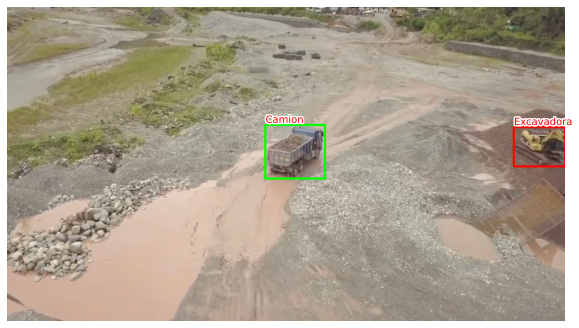

In [7]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
ds = OpenImages(df,IMAGE_ROOT)
image , boxes , classes , _ = ds[6]
show(image, bbs = boxes, texts = classes, sz = 10, bb_colors = [[255, 0, 0], [0, 255, 0]])

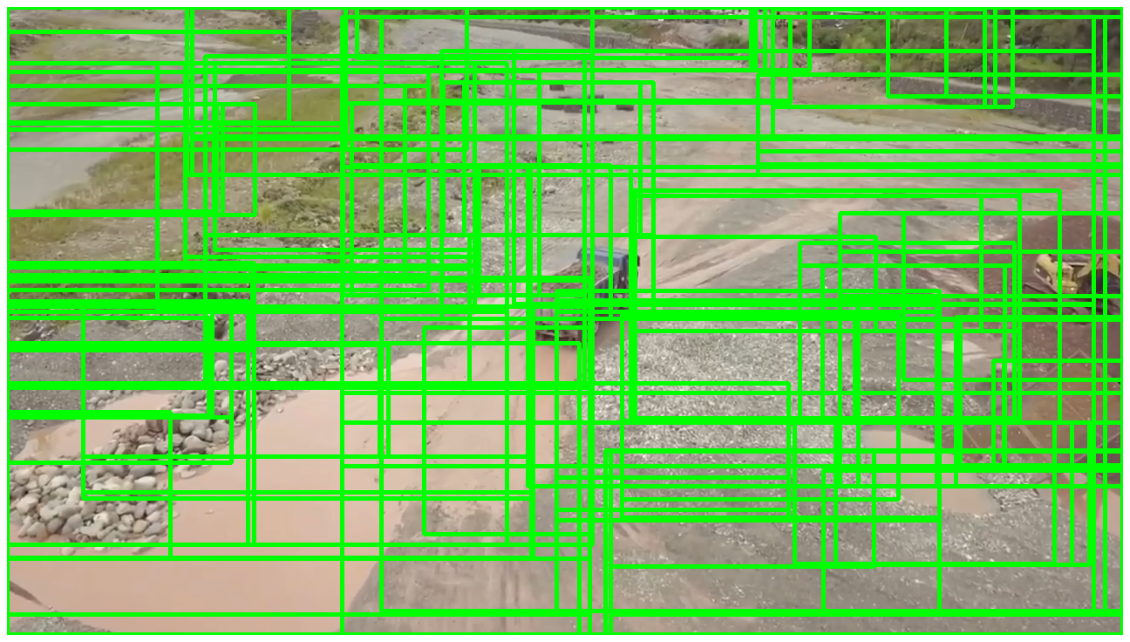

In [ ]:
image = cv2.imread(IMAGE_ROOT + '/imagen_1154.png',1)[...,::-1]
candidates = extract_candidates(image)
candidates = np.array([[x,y,x + w, y +h] for x,y,w,h in candidates])
show(image,bbs=candidates)

In [8]:
def extract_candidates(img):
  img_lbl, regions = selectivesearch.selective_search(img,scale = 100, min_size=10)
  img_area = np.prod(img.shape[:2])
  candidates = []
  for r in regions:
    # x, y, w, h = r['rect']
    if r['rect'] in candidates : continue
    if r['size'] < (0.01*img_area) : continue 
    if r['size'] > (1*img_area): continue
    candidates.append(list(r['rect']))
  return candidates

def calculate_iou(boxA,boxB, epsilon = 1e-5):
  x1 = max(boxA[0],boxB[0])
  y1 = max(boxA[1],boxB[1])
  x2 = min(boxA[2],boxB[2])
  y2 = min(boxA[3],boxB[3])
  width = x2 - x1
  hight = y2 - y1
  if (width < 0) or (hight < 0):
    return 0.0
  area_overlap = width * hight
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b  - area_overlap
  iou = area_overlap / (area_combined + epsilon)
  return iou

## Load DataSet

In [9]:
import pickle
# Read listas
  
with open("/content/drive/MyDrive/Vision Artificial/Data/Rois/FPATHS.txt", "rb") as fp:   #Pickling
  FPATHS = pickle.load(fp)
with open("/content/drive/MyDrive/Vision Artificial/Data/Rois/GTBBS.txt", "rb") as fp:   #Pickling
  GTBBS = pickle.load(fp)
with open("/content/drive/MyDrive/Vision Artificial/Data/Rois/CLSS.txt", "rb") as fp:   #Pickling
  CLSS = pickle.load(fp)
with open("/content/drive/MyDrive/Vision Artificial/Data/Rois/DELTAS.txt", "rb") as fp:   #Pickling
  DELTAS = pickle.load(fp)
with open("/content/drive/MyDrive/Vision Artificial/Data/Rois/ROIS.txt", "rb") as fp:   #Pickling
  ROIS = pickle.load(fp)

FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.png' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [10]:
FPATHS[0]

'/content/drive/MyDrive/Vision Artificial/Data/Imagenes/imagen_0001.png'

In [12]:
## Imgen prepocesing
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  img = normalize(img)
  return img.to(device).float()

def decode(_y):
  _, preds = _y.max(-1)
  return preds

In [29]:
targets = [label for label in list(set(flatten(CLSS))) if label != 'background']
label2target = {l:(t + 1)  for t,l in enumerate(targets)}
background_class = 0
label2target['background']= background_class
target2label = {t:l for l,t in label2target.items()}

In [ ]:
with open("/content/drive/MyDrive/Vision Artificial/models/FRCNN/target2label.txt", "rb") as fp:   #Pickling
  a = pickle.load(fp)

In [ ]:
# save 
import pickle
with open('/content/drive/MyDrive/Vision Artificial/models/FRCNN/label2target2.txt','wb') as fp:
  pickle.dump(label2target,fp)

with open('/content/drive/MyDrive/Vision Artificial/models/FRCNN/target2label2.txt','wb') as fp:
  pickle.dump(target2label,fp)

In [31]:
# Load
with open('/content/drive/MyDrive/Vision Artificial/models/ss/label2target2.txt','rb') as fp:
  label2target = pickle.load(fp)
with open('/content/drive/MyDrive/Vision Artificial/models/FRCNN/target2label2.txt','rb') as fp:
  target2label = pickle.load(fp)

In [14]:
class FRCNNDataset(Dataset):
  def __init__(self,fpaths, rois, labels, deltas, gtbbs):
    self.fpaths = fpaths
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
    self.gtbbs = gtbbs
  
  def __len__(self): return len(self.fpaths)
  
  def __getitem__(self,ix):
    fpath = self.fpaths[ix]
    #print(fpath)
    image = cv2.imread(fpath,1)[...,::-1]
    gtbbs = self.gtbbs[ix]
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    rois = self.rois[ix]
    assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
    return image, rois, labels, deltas, gtbbs, fpath

  def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [15]:
from sklearn.model_selection import train_test_split
indexes = range(len(FPATHS))
idx_train , idx_test = train_test_split(indexes, test_size = 0.1,random_state = 42,shuffle = True) 

In [22]:
train_FPATHS = [FPATHS[idx] for idx in idx_train] 
train_ROIS = [ROIS[idx] for idx in idx_train] 
train_CLSS = [CLSS[idx] for idx in idx_train] 
train_DELTAS = [DELTAS[idx] for idx in idx_train] 
train_GTBBS = [GTBBS[idx] for idx in idx_train] 

train_ds = FRCNNDataset(
    train_FPATHS,
    train_ROIS,
    train_CLSS,
    train_DELTAS,
    train_GTBBS
    )

test_FPATHS = [FPATHS[idx] for idx in idx_test] 
test_ROIS = [ROIS[idx] for idx in idx_test] 
test_CLSS = [CLSS[idx] for idx in idx_test] 
test_DELTAS = [DELTAS[idx] for idx in idx_test] 
test_GTBBS = [GTBBS[idx] for idx in idx_test] 

test_ds = FRCNNDataset(
    test_FPATHS,
    test_ROIS,
    test_CLSS,
    test_DELTAS,
    test_GTBBS
    )

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

## Define Model

In [16]:

from torchvision.ops import RoIPool
import torchvision

class FRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # Load pretrained model
    rawnet = torchvision.models.vgg16_bn(pretrained = True)
    # freeze the parameters
    for param in rawnet.features.parameters():
      param.requires_grad = True
    # Extract features hasta la ultima capa
    self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
    # Especificar RoIPool . Salida 7 x 7
    self.roipool =  RoIPool(7,spatial_scale=14/224)
    # Define las salidas 
    feature_dim = 512*7*7
    self.cls_score = nn.Linear(feature_dim, len(label2target) + 1)
    self.bbox = nn.Sequential(
        nn.Linear(feature_dim,512),
        nn.ReLU(),
        nn.Linear(512,4),
        nn.Tanh())
    self.cel = nn.CrossEntropyLoss()
    self.sl1 = nn.L1Loss()

  def forward(self, input, rois, ridx):
      res = input
      res = self.seq(res)
      rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
      res = self.roipool(res, rois)
      feat = res.view(len(res), -1)
      cls_score = self.cls_score(feat)
      bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
      return cls_score, bbox
  
  def calc_loss(self, probs, _deltas, labels, deltas):
      detection_loss = self.cel(probs, labels)
      ixs, = torch.where(labels != background_class)
      _deltas = _deltas[ixs]
      deltas = deltas[ixs]
      self.lmb = 10.0
      if len(ixs) > 0:
          regression_loss = self.sl1(_deltas, deltas)
          return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
      else:
          regression_loss = 0
          return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

## Training

In [17]:

def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 1.000	trn_loss: 1.368	trn_loc_loss: 0.537	trn_regr_loss: 0.083	trn_acc: 0.868	val_loss: 1.160	val_loc_loss: 0.410	val_regr_loss: 0.075	val_acc: 0.875	(1952.69s - 56627.88s remaining)
EPOCH: 2.000	trn_loss: 0.940	trn_loc_loss: 0.322	trn_regr_loss: 0.062	trn_acc: 0.907	val_loss: 1.062	val_loc_loss: 0.356	val_regr_loss: 0.071	val_acc: 0.887	(2100.83s - 29411.56s remaining)
EPOCH: 3.000	trn_loss: 0.740	trn_loc_loss: 0.244	trn_regr_loss: 0.050	trn_acc: 0.929	val_loss: 0.996	val_loc_loss: 0.324	val_regr_loss: 0.067	val_acc: 0.893	(2248.46s - 20236.17s remaining)
EPOCH: 4.000	trn_loss: 0.633	trn_loc_loss: 0.196	trn_regr_loss: 0.044	trn_acc: 0.942	val_loss: 1.001	val_loc_loss: 0.304	val_regr_loss: 0.070	val_acc: 0.901	(2395.79s - 15572.64s remaining)
EPOCH: 5.000	trn_loss: 0.553	trn_loc_loss: 0.164	trn_regr_loss: 0.039	trn_acc: 0.951	val_loss: 0.970	val_loc_loss: 0.295	val_regr_loss: 0.068	val_acc: 0.905	(2543.31s - 12716.56s remaining)
EPOCH: 6.000	trn_loss: 0.495	trn_loc_loss: 0.140	t

100%|██████████| 131/131 [00:00<00:00, 160.09it/s]


EPOCH: 30.000	trn_loss: 0.199	trn_loc_loss: 0.028	trn_regr_loss: 0.017	trn_acc: 0.995	val_loss: 0.845	val_loc_loss: 0.278	val_regr_loss: 0.057	val_acc: 0.921	(6215.08s - 0.00s remaining)


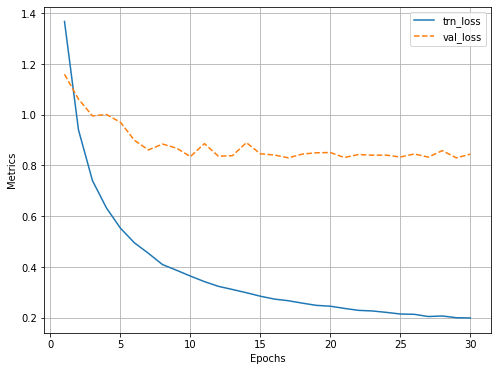

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 30
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
torch.save(frcnn,
    '/content/drive/MyDrive/Vision Artificial/models/FRCNN/frcnn2.pth')

## Evaluacion

In [18]:
frcnn = torch.load(
    '/content/drive/MyDrive/Vision Artificial/models/FRCNN/frcnn2.pth',
    map_location=torch.device(device))

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

def test_predictions(fpath, show_image = True):
    img = cv2.resize(np.array(Image.open(fpath)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        #print(probs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)

    if show_image:
      ## Ground true
      #print(fpath)
      filename = fpath.split('/')[-1]
      df_bbs = df[df.filename == filename ]
      boxes = df_bbs[['label','xmin','ymin','xmax','ymax']].values
      #print(boxes)
      img_temp = cv2.imread(fpath,1)[...,::-1]
      H,W,_= img_temp.shape
      gtbbs = boxes[:,1:] *224.0/ np.array([W,H,W,H])
      gtbbs = gtbbs.astype(np.int32)
      #print(gtbbs)
      #print(bbs)
      true_class = df_bbs['label'].values.tolist()
      _, ax = plt.subplots(1, 2, figsize=(20,10))
      show(img, ax=ax[0],bbs =gtbbs, texts= true_class)
      ax[0].grid(False)
      ax[0].set_title(filename.split('/')[-1])
      if len(confs) == 0:
          ax[1].imshow(img)
          ax[1].set_title('No objects')
          plt.show()
          return confs, clss , bbs
      else:
          show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
          plt.show()
    return confs, clss , bbs

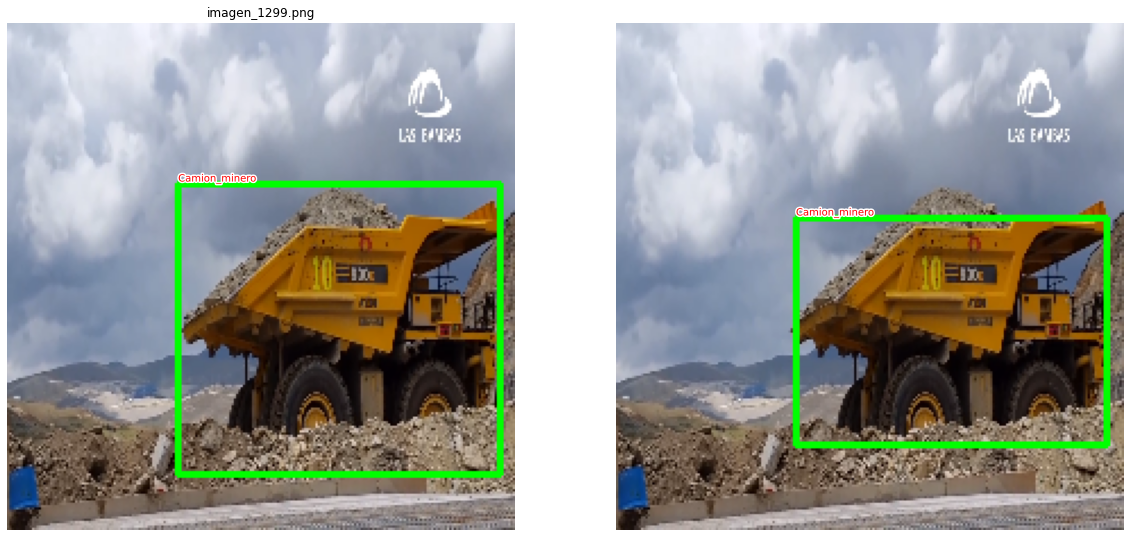

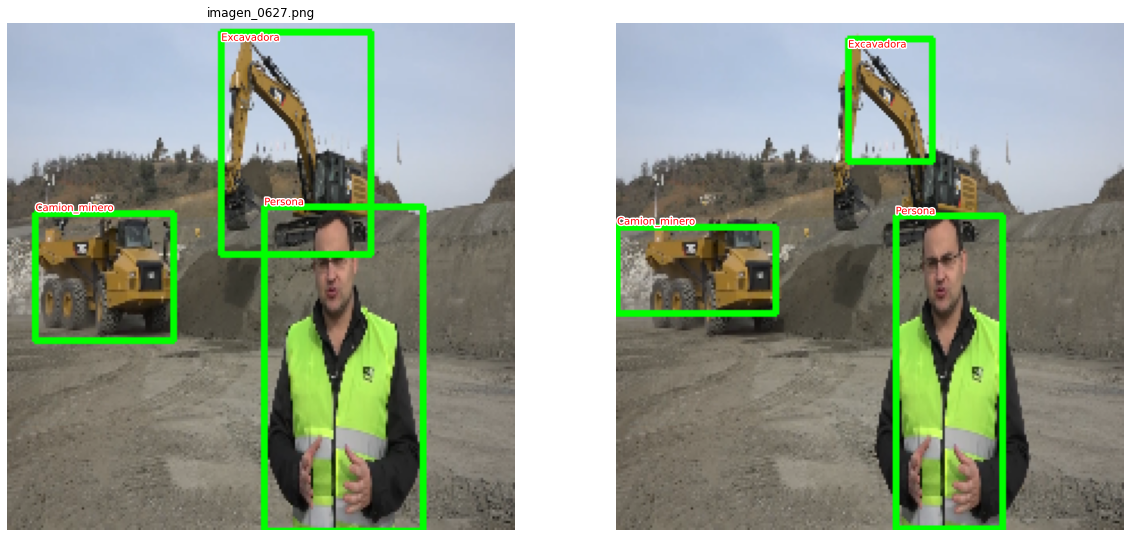

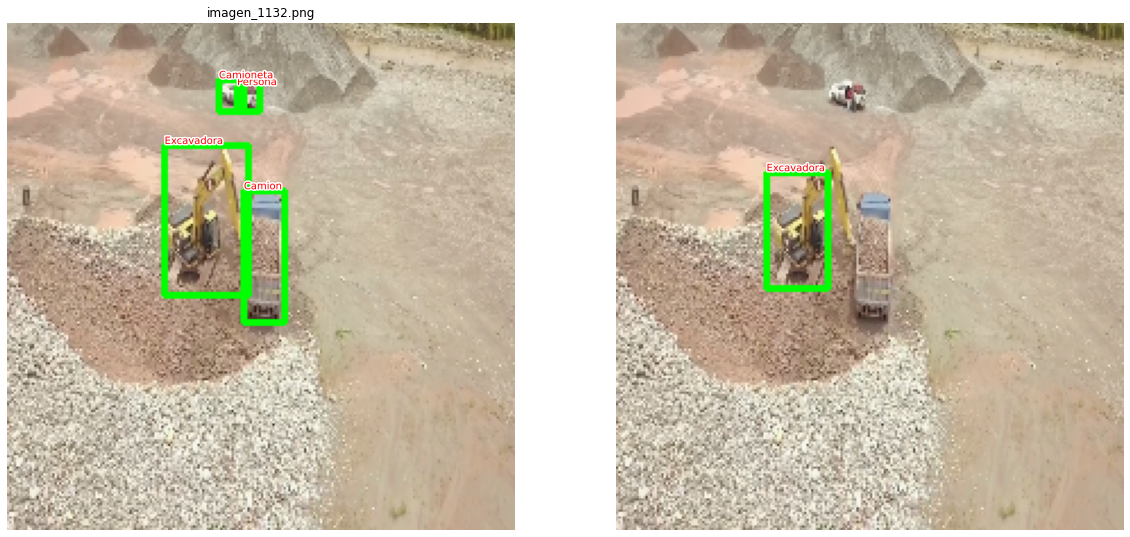

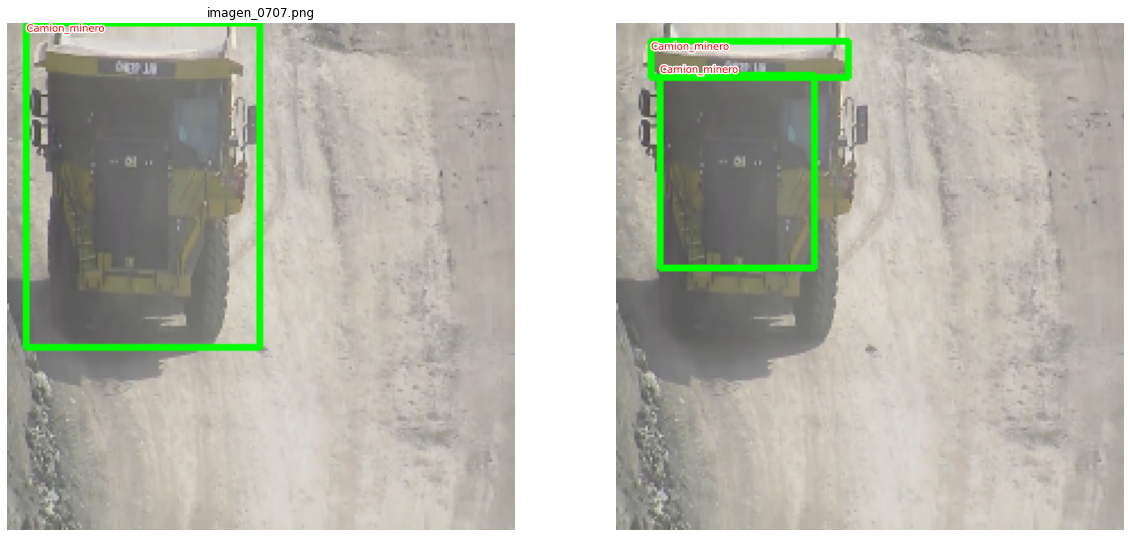

In [53]:
import random

idxs = random.choices(range(0,len(test_ds)),k = 4)
for ix in idxs:
  test_predictions(test_ds[ix][-1],show_image=True)

### Average Precision

In [35]:
## Crea la lista de prediciones para el conjunto de prueba
pred_boxes = [] # [idx_image, class_prediction, prob_score, x1, y1, x2, y2]
true_boxes = [] # [idx_image, class, x1, y1, x2, y2]

for _,_,_,_,_, fpath in test_ds: ## image, rois, labels, deltas, gtbbs, fpath
  filename = fpath.split('/')[-1]
  df_bbs = df[df.filename == filename ]
  boxes = df_bbs[['filename','label','xmin','ymin','xmax','ymax']].values
  img = cv2.imread(fpath,1)[...,::-1]
  H,W,_= img.shape
  gtbbs = boxes[:,2:] *224.0/ np.array([W,H,W,H])
  gtbbs = gtbbs.astype(np.int32)
  boxes[:,2:] =  gtbbs
  #print(H,W)
  #print(gtbbs)
  pred_confs, pred_clss , pred_bbs = test_predictions(fpath,show_image=False)
  if len(pred_confs) == 0 : continue
  predictions =  [[filename,target2label[pred_cls],conf,*pred_bb ] for pred_cls, conf, pred_bb in zip( pred_clss ,pred_confs, pred_bbs)]
  pred_boxes.extend(predictions)
  true_boxes.extend(boxes)

In [36]:
pred_boxes[0]

['imagen_1171.png', 'Excavadora', 9.4056425, 0, 89, 45, 129]

In [37]:
from collections import Counter

def mean_average_precision(pred_boxes,true_boxes, classes,iou_threshold = 0.5):
  """
  Calculate mean average precision

  Paramenters:
      pred_boxes: list of lists containing all prediction bboxes. 
                  Each boxes is like [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
      true_boxes: Similar as pred_boxes except all the correct ones 
      iou_threshold: threshold where predicted bboxes is correct
      classes: classes

  Returns:
    float: mAP value across all classes given a specific IoU threshold
  """
  average_precisions = []
  classes_mAP = {}
  epsilon = 1e-6
  AP_table_info = pd.DataFrame([], columns = ['image','class','confidence',
                                      'iou','iou>0.5','Cum_TP','Cum_FP',
                                      'Precision','Recall'])
  for c in classes:
    detections = []
    ground_truts = []
    
    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)
    
    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truts.append(true_box)
    # amount_bboxes = {'image1':2 , 'image2':5}
    amount_bboxes = Counter([gt[0] for gt in ground_truts])
    for key , val in amount_bboxes.items():
      amount_bboxes[key] = np.zeros(val,dtype=np.int32)
    detections.sort(key = lambda x: x[2], reverse = True)
    TP = np.zeros(len(detections))
    FP = np.zeros(len(detections))
    total_true_bboxes = len(ground_truts)
    detections_ious = []
    if total_true_bboxes == 0:
      continue
    for detection_idx , deteccion in enumerate(detections):
      idx_image = deteccion[0]
      ground_truth_img = [ bbox for bbox in ground_truts if bbox[0] == idx_image]
      num_gts = len(ground_truth_img)
      best_iou = 0
      for idx, gt in enumerate(ground_truth_img):
        iou = calculate_iou(
            deteccion[3:],
            gt[2:])

        if iou > best_iou :
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:
        if isinstance(amount_bboxes[idx_image], np.ndarray) and amount_bboxes[idx_image][best_gt_idx] == 0:
          TP[detection_idx] = 1
        else:
          FP[detection_idx] = 1
      else:
        FP[detection_idx] = 1
      
      detections_ious.append([idx_image,deteccion[1],deteccion[2],best_iou, best_iou > iou_threshold ])

    TP_cumsum = np.cumsum(TP, axis = 0)
    FP_cumsum = np.cumsum(FP, axis = 0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
    # Append table info
    AP_class = [ [*_detection,TP_cum,FP_cum,precision,recall] 
                for _detection, TP_cum, FP_cum, precision, recall in zip(detections_ious,TP_cumsum,FP_cumsum,precisions,recalls)]
    AP_table_class = pd.DataFrame(AP_class, columns=AP_table_info.columns)
    AP_table_info = AP_table_info.append(AP_table_class, ignore_index = True)
    # mean precision. Area bajo la curva
    precisions = np.concatenate((np.array([1]), precisions))
    recalls = np.concatenate((np.array([0]), recalls))
    classes_mAP[c] = np.trapz(precisions, recalls)
    average_precisions.append(np.trapz(precisions, recalls))
    mAP = sum(average_precisions) / len(average_precisions)
  return mAP, classes_mAP,AP_table_info

In [50]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precisions, recalls,ax,cls):
  ax.plot(recalls,precisions,linewidth=2, color ='red')
  ax.set_xlabel('Recall', fontsize = 12, fontweight = 'bold')
  ax.set_ylabel('Precision', fontsize = 12,fontweight = 'bold')
  ax.set_title('Precision-Recall Curve ({})'.format(cls), fontsize = 15,fontweight = 'bold')
  ax.set_ylim(bottom=0)
  ax.set_xlim(left=0)
  #ax.show()

In [39]:
classes = [ key for key in label2target.keys() if key != 'background']
classes
mAP , classes_mAP ,  AP_table_info = mean_average_precision(pred_boxes,true_boxes,classes)
print('mAP:', mAP)
classes_mAP

mAP: 0.05075232200398177


{'Auto': 0.0,
 'Bulldozer': 0.11858969093115201,
 'Camion': 0.08144014499313174,
 'Camion_minero': 0.03418554125602218,
 'Camioneta': 0.0,
 'Excavadora': 0.0990803115392297,
 'Otro': 0.04409081674646676,
 'Persona': 0.02863207056585176}

In [40]:
AP_table_info.head(5)

,image,class,confidence,iou,iou>0.5,Cum_TP,Cum_FP,Precision,Recall
0,imagen_0616.png,Persona,13.693521,0.151049,False,0.0,1.0,0.000000,0.000000
1,imagen_0627.png,Persona,13.221814,0.647952,True,1.0,1.0,0.500000,0.022727
2,imagen_0622.png,Persona,13.194497,0.102700,False,1.0,2.0,0.333333,0.022727
3,imagen_1034.png,Persona,12.678622,0.188662,False,1.0,3.0,0.250000,0.022727
4,imagen_0495.png,Persona,12.325153,0.274925,False,1.0,4.0,0.200000,0.022727


In [41]:
 AP_table_info[AP_table_info['class'] == 'Camion']

,image,class,confidence,iou,iou>0.5,Cum_TP,Cum_FP,Precision,Recall
38,imagen_0887.png,Camion,14.034798,0.493412,False,0.0,1.0,0.000000,0.000000
39,imagen_0372.png,Camion,13.416268,0.659339,True,1.0,1.0,0.500000,0.015873
40,imagen_0552.png,Camion,12.137223,0.236842,False,1.0,2.0,0.333333,0.015873
41,imagen_0519.png,Camion,11.589509,0.712959,True,2.0,2.0,0.500000,0.031746
42,imagen_0030.png,Camion,11.451660,0.899501,True,3.0,2.0,0.600000,0.047619
43,imagen_0372.png,Camion,10.477609,0.048461,False,3.0,3.0,0.500000,0.047619
44,imagen_1002.png,Camion,10.104041,0.514620,True,4.0,3.0,0.571428,0.063492
45,imagen_0301.png,Camion,9.974494,0.658686,True,5.0,3.0,0.625000,0.079365
46,imagen_0343.png,Camion,9.716952,0.412521,False,5.0,4.0,0.555555,0.079365
47,imagen_0352.png,Camion,9.577164,0.241224,False,5.0,5.0,0.500000,0.079365


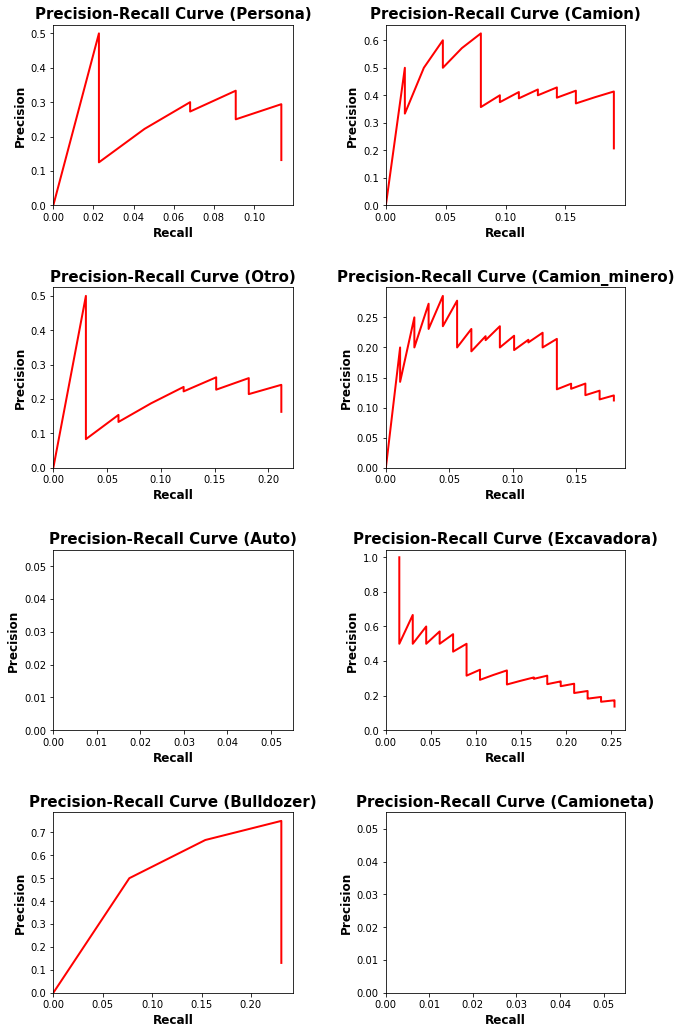

In [51]:
figure, ax = plt.subplots(int(len(classes_mAP) / 2) + len(classes_mAP) %2 , 2, figsize=(10,15))

for idx ,cls in enumerate(classes_mAP.keys()):
  AP_table_class = AP_table_info[AP_table_info['class'] == cls]
  precisions = AP_table_class['Precision'].values.tolist()
  recalls = AP_table_class['Recall'].values.tolist()
  plot_precision_recall_curve(
      precisions,recalls,
      ax=ax[int(idx /2)][idx %2],
      cls= cls)
figure.tight_layout(pad=3.0)